/home/temp-user/workspace/plate-recognition-low-resolution/.venv-preprocess/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 3 images to test

🚀 Loading Model: Qwen/Qwen3-VL-4B-Instruct...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.13s/it]
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Model Ready

[1/3] Processing: hr-001.png
   Output: {
  "bbox_2d": [138, 468, 888, 948]
}
   Processed Size: 1008x336
   ✅ Detected 1 bbox


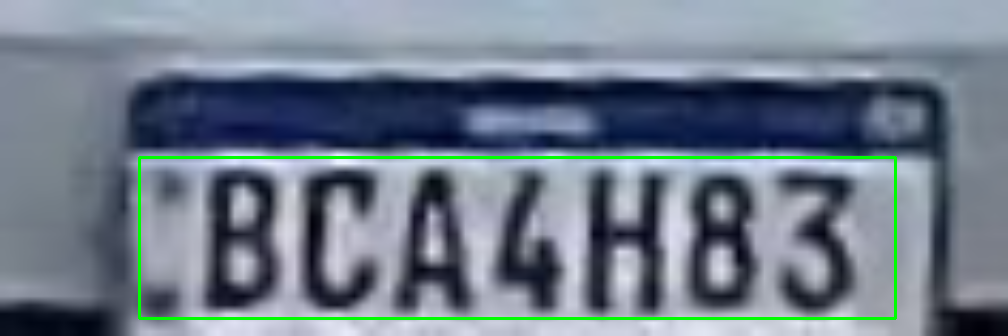


[2/3] Processing: hr-002.png
   Output: {
  "bbox_2d": [104, 387, 856, 874]
}
   Processed Size: 1008x336
   ✅ Detected 1 bbox


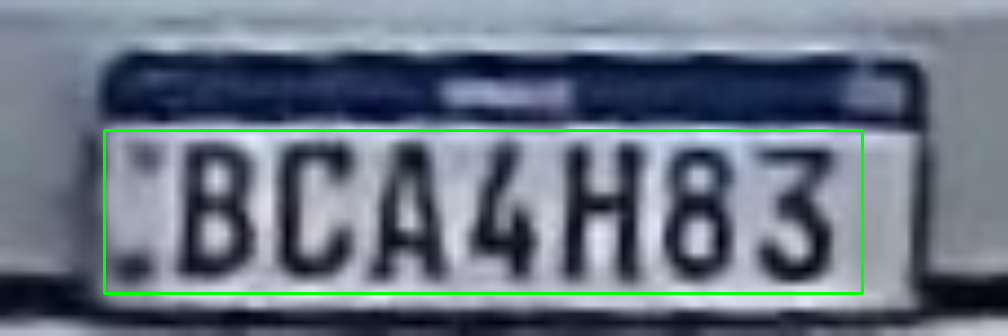


[3/3] Processing: hr-003.png
   Output: {
  "bbox_2d": [130, 484, 900, 984]
}
   Processed Size: 1008x336
   ✅ Detected 1 bbox


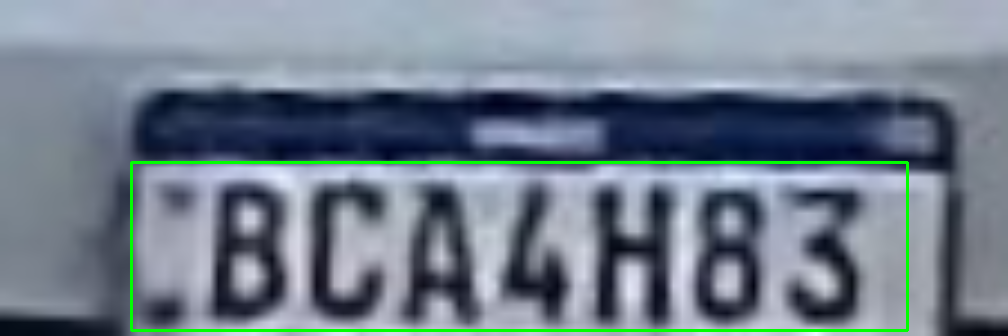

In [1]:
# ==================== INSTALLATION ====================
# !pip install transformers torch pillow supervision albumentations opencv-python

import os
import torch
import json
import cv2
import numpy as np
import albumentations as A
from PIL import Image
from transformers import AutoProcessor, AutoModelForImageTextToText
import supervision as sv
from typing import List, Tuple, Optional

# ==================== CONFIG ====================
class Config:
    # Model Qwen
    QWEN_MODEL_ID = "Qwen/Qwen3-VL-4B-Instruct" 
    
    # Dataset path
    DATASET_PATH = "/home/temp-user/workspace/plate-recognition-low-resolution/data/processed_rec/train_rec.txt"
    
    # Kích thước ảnh target để model detect tốt hơn (Height, Width)
    TARGET_SIZE = (336, 1008) 
    
    MAX_NEW_TOKENS = 128
    
    # Palette màu cho visualize
    COLOR_PALETTE = sv.ColorPalette.from_hex([
        "#00ff00", "#ff0000", "#0000ff", "#ffff00"
    ])

# ==================== DATA LOADER ====================
def load_dataset(limit: int = 10) -> List[dict]:
    """Đọc file txt dataset (format: image_path\tlabel)"""
    samples = []
    if not os.path.exists(Config.DATASET_PATH):
        print(f"⚠️ File not found: {Config.DATASET_PATH}")
        return samples

    with open(Config.DATASET_PATH, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if limit and len(samples) >= limit:
                break
            line = line.strip()
            if not line: continue
            
            parts = line.split('\t')
            if len(parts) >= 1:
                img_path = parts[0]
                if os.path.exists(img_path):
                    samples.append({
                        "image_path": img_path,
                        "label": parts[1] if len(parts) > 1 else "Unknown"
                    })
    return samples

# ==================== PREPROCESSOR ====================
class ImagePreprocessor:
    def __init__(self, target_size=Config.TARGET_SIZE):
        # Resize ảnh nhỏ lên kích thước lớn hơn
        self.transform = A.Compose([
            A.Resize(height=target_size[0], width=target_size[1], interpolation=cv2.INTER_CUBIC, p=1),
        ])
    
    def process(self, image: Image.Image) -> Tuple[Image.Image, float, float]:
        """Resize và trả về (ảnh mới, scale_w, scale_h)"""
        img_np = np.array(image)
        original_h, original_w = img_np.shape[:2]
        
        # Apply transform
        augmented = self.transform(image=img_np)
        img_aug = augmented['image']
        
        new_h, new_w = img_aug.shape[:2]
        scale_w = original_w / new_w
        scale_h = original_h / new_h
        
        return Image.fromarray(img_aug), scale_w, scale_h

# ==================== QWEN DETECTOR ====================
class QwenDetector:
    def __init__(self, model_id: str = Config.QWEN_MODEL_ID):
        print(f"🚀 Loading Model: {model_id}...")
        self.processor = AutoProcessor.from_pretrained(model_id)
        self.model = AutoModelForImageTextToText.from_pretrained(
            model_id,
            torch_dtype=torch.float16,    # Flash Attention yêu cầu fp16 hoặc bf16
            device_map="cuda",
            attn_implementation="flash_attention_2"  
        )
        self.preprocessor = ImagePreprocessor(target_size=Config.TARGET_SIZE)
        print("✅ Model Ready")
    
    # Sửa return type để trả về cả processed_image
    def detect(self, image: Image.Image) -> Tuple[str, Image.Image]:
        # 1. Preprocess: Resize ảnh TO LÊN
        processed_image, _, _ = self.preprocessor.process(image)
        
        # 2. Prompt
        prompt = """
        Task: Detect the precise license plate text region.
        Step 1: Analyze the image and identify the exact pixels where the text starts (left) and ends (right).
        Step 2: Identify the top and bottom edges of the characters.
        Step 3: Reason about the boundaries - ensure no background is included, but no text is cut.
        Step 4: Output the result.

        Return JSON format:
        {"bbox_2d": [x1, y1, x2, y2]}
        """
        
        messages = [{
            "role": "user",
            "content": [
                {"type": "image", "image": processed_image},
                {"type": "text", "text": prompt}
            ]
        }]
        
        inputs = self.processor.apply_chat_template(
            messages, tokenize=True, add_generation_prompt=True,
            return_dict=True, return_tensors="pt"
        ).to("cuda")
        
        with torch.inference_mode():
            gen = self.model.generate(
                **inputs, 
                max_new_tokens=Config.MAX_NEW_TOKENS, 
                temperature=0.1, 
                do_sample=False
            )
        
        new_tokens = gen[0][inputs.input_ids.shape[1]:]
        result = self.processor.decode(new_tokens, skip_special_tokens=True).strip()
        
        if result.startswith("```json"):
            result = result.replace("```json", "").replace("```", "").strip()
            
        return result, processed_image

class Visualizer:
    @staticmethod
    def annotate(image: Image.Image, detections: sv.Detections) -> Image.Image:
        text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
        thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
        
        # Tăng thickness lên chút cho dễ nhìn với ảnh nhỏ
        thickness = max(thickness, 2)
        
        box_annotator = sv.BoxAnnotator(color=Config.COLOR_PALETTE, thickness=thickness)
        annotated = image.copy()
        
        try:
            annotated = box_annotator.annotate(annotated, detections)
        except Exception as e:
            print(f"Viz Error: {e}")
            
        return annotated

# ==================== PARSER ====================
def parse_detections(result_str: str, img_w: int, img_h: int) -> sv.Detections:
    try:
        data = json.loads(result_str)
        
        xyxy = []
        class_id = []
        confidence = []
        # Helper function để trích xuất bbox từ 1 item
        def extract_bbox(item):
            # Case 1: Standard flat format
            if "bbox_2d" in item:
                return item["bbox_2d"]
            
            # Case 2: Nested format (như log bạn thấy)
            # data = {"license_plate": {"bbox_2d": [...]}}
            for key, val in item.items():
                if isinstance(val, dict) and "bbox_2d" in val:
                    return val["bbox_2d"]
            return None
        # Handle list vs dict
        if isinstance(data, dict):
             # Check nếu chính cái dict ngoài cùng chứa thông tin (Case 2 của bạn)
            bbox = extract_bbox(data)
            if bbox:
                items = [{"bbox_2d": bbox}] # Fake lại cấu trúc để loop dưới xử lý
            else:
                items = [data]
        else:
            items = data
        for item in items:
            box = extract_bbox(item)
            
            if box and len(box) == 4:
                # Normalize [xmin, ymin, xmax, ymax] (1000 scale)
                x1 = box[0] / 1000 * img_w
                y1 = box[1] / 1000 * img_h
                x2 = box[2] / 1000 * img_w
                y2 = box[3] / 1000 * img_h
                
                xyxy.append([x1, y1, x2, y2])
                class_id.append(0)
                confidence.append(1.0)
        
        if not xyxy: return sv.Detections.empty()
        
        return sv.Detections(
            xyxy=torch.tensor(xyxy).numpy(),
            class_id=np.array(class_id),
            confidence=np.array(confidence)
        )
    except Exception as e:
        print(f"   ⚠️ Parse Error: {e} | Raw: {result_str}")
        return sv.Detections.empty()
# ==================== MAIN RUN (SỬA ĐỔI) ====================
def run_demo():
    import glob
    
    # Test tất cả ảnh trong track_09989
    track_path = "/home/temp-user/workspace/plate-recognition-low-resolution/data/preprocessed/Scenario-A/Mercosur/track_09989"
    test_images = sorted(glob.glob(f"{track_path}/hr-*.png"))[:3]  # Test 3 ảnh HR đầu
    
    print(f"Found {len(test_images)} images to test\n")
    detector = QwenDetector()
    visualizer = Visualizer()
    
    for i, img_path in enumerate(test_images):  # ← SỬA: img_path thay vì sample
        img_name = os.path.basename(img_path)  # ← SỬA: img_path
        print(f"\n[{i+1}/{len(test_images)}] Processing: {img_name}")  # ← SỬA: test_images thay vì samples
        
        try:
            image_org = Image.open(img_path).convert("RGB")  # ← SỬA: img_path thay vì sample['image_path']
            
            # Detect -> Lấy về ảnh đã resize
            result_text, processed_image = detector.detect(image_org)
            w, h = processed_image.size
            print(f"   Output: {result_text}")
            print(f"   Processed Size: {w}x{h}")
            
            # Parse không cần scale nữa
            detections = parse_detections(result_text, img_w=w, img_h=h)
            
            # Visualize trực tiếp trên ảnh resize
            if len(detections) > 0:
                print(f"   ✅ Detected {len(detections)} bbox")
                annotated_image = visualizer.annotate(processed_image, detections)
                try:
                    display(annotated_image)
                except NameError:
                    annotated_image.show()
            else:
                print("   ❌ No detections")
                
        except Exception as e:
            print(f"   ⚠️ Error: {e}")
if __name__ == "__main__":
    run_demo()

Random track: /home/temp-user/workspace/plate-recognition-low-resolution/data/preprocessed/Scenario-B/Mercosur/track_18706


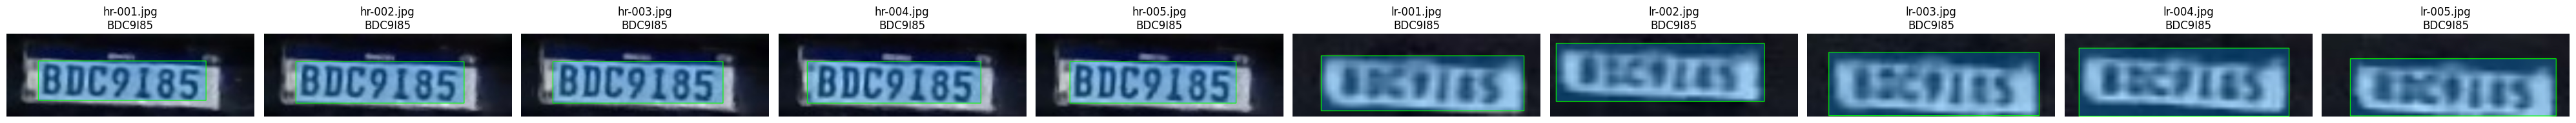

In [26]:
import json
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_ROOT = Path("/home/temp-user/workspace/plate-recognition-low-resolution/data/preprocessed")

def get_random_track(data_root: Path = DATA_ROOT) -> Path:
    """Random chọn một track từ data directory."""
    all_tracks = []
    for scenario in data_root.iterdir():
        if scenario.is_dir():
            for layout in scenario.iterdir():
                if layout.is_dir():
                    for track in layout.iterdir():
                        if track.is_dir() and track.name.startswith("track_"):
                            all_tracks.append(track)
    return random.choice(all_tracks)

def visualize_track(track_dir: str = None, show_all: bool = True):
    """Visualize bbox annotations for a track."""
    if track_dir is None:
        track_path = get_random_track()
        print(f"Random track: {track_path}")
    else:
        track_path = Path(track_dir)
    
    ann_file = track_path / "annotations.json"
    if not ann_file.exists():
        print(f"No annotations.json in {track_path}")
        return
    
    with open(ann_file) as f:
        ann = json.load(f)
    
    corners = ann.get("corners", {})
    plate_text = ann.get("plate_text", "")
    
    images = list(corners.keys()) if show_all else list(corners.keys())[:3]
    n = len(images)
    
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    if n == 1: axes = [axes]
    
    for ax, img_name in zip(axes, images):
        img_path = track_path / img_name
        img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
        
        c = corners[img_name]
        pts = np.array([c["top-left"], c["top-right"], c["bottom-right"], c["bottom-left"]], dtype=np.float32)
        # Tính center của polygon
        center = pts.mean(axis=0)
        # Nới rộng mỗi điểm ra 10 pixel theo hướng từ center
        expand = 10
        for i in range(len(pts)):
            direction = pts[i] - center
            direction = direction / np.linalg.norm(direction)  # normalize
            pts[i] = pts[i] + direction * expand
        pts = pts.astype(np.int32)
        
        # Tạo overlay với fill xanh mờ
        overlay = img.copy()
        cv2.fillPoly(overlay, [pts], (0, 150, 255))  # Màu xanh dương
        alpha = 0.3  # Opacity 30%
        img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)
        
        # Vẽ viền xanh lá
        cv2.polylines(img, [pts], isClosed=True, color=(0, 255, 0), thickness=2)
        
        ax.imshow(img)
        ax.set_title(f"{img_name}\n{plate_text}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

# Chạy visualization với random track
visualize_track()